In [1]:
from dataclasses import dataclass

from scipy.integrate import quad
import pandas as pd
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Construct SNe Model

In [2]:
sne_df = pd.read_csv('lcparam_full_long_zhel.txt', sep=' ')
sne_df.sort_values('zcmb', inplace=True)
# zcmb is redshift, dmb is magnitude error.

In [3]:
sne_df

,name,zcmb,zhel,dz,mb,dmb,x1,dx1,color,dcolor,3rdvar,d3rdvar,cov_m_s,cov_m_c,cov_s_c,set,ra,dec,biascor
583,2002cr,0.01012,0.009351,0.0,13.90745,0.19825,0,0,0,0,0,0,0,0,0,0,0,0,NaN
585,2002dp,0.01038,0.011640,0.0,14.04960,0.20480,0,0,0,0,0,0,0,0,0,0,0,0,NaN
677,2009an,0.01043,0.008969,0.0,13.92480,0.20035,0,0,0,0,0,0,0,0,0,0,0,0,NaN
702,2006bh,0.01082,0.010767,0.0,14.00860,0.18445,0,0,0,0,0,0,0,0,0,0,0,0,NaN
728,1998dk,0.01209,0.013201,0.0,13.97910,0.19140,0,0,0,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,Primo,1.55000,1.550387,0.0,26.00705,0.18565,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1026,geta,1.70000,1.701108,0.0,26.05920,0.28320,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1027,stone,1.80000,1.799601,0.0,26.20110,0.18795,0,0,0,0,0,0,0,0,0,0,0,0,NaN
1029,wilson,1.91400,1.914829,0.0,26.16090,0.25590,0,0,0,0,0,0,0,0,0,0,0,0,NaN


In [4]:
# Fisher contour center vector.
OMEGA_M = 0.30
DE_EOS_W = -1
NUISANCE = 0
LABELS = ['$\Omega_M$', '$w$', '$\mathcal{M}$']

@dataclass
class SNeModel:
    Omega_M: float
    w: float
    nuisance: float
    
    def __post_init__(self):
        assert 0 <= self.Omega_M <= 1
        # Since flat universe.
        self.Omega_Lambda = 1 - self.Omega_M
        
    # This becomes the entire expression in the log10 in Equation 12.7.
    def d_L_times_H0(self, z):
        def E(zp):
            return 1 / np.sqrt(self.Omega_M * (1 + zp)**3 + self.Omega_Lambda * (1 + zp)**(3 * (1 + self.w)))
        return (1 + z) * quad(E, 0, z)[0]
    
    def apparent_mag(self):
        return 5 * np.log10(np.array([self.d_L_times_H0(z) for z in sne_df.zcmb])) + self.nuisance
    
MU_MODEL = SNeModel(OMEGA_M, DE_EOS_W, NUISANCE)
MU_VEC = MU_MODEL.apparent_mag()

In [5]:
MU_VEC

array([-9.9571934 , -9.90167823, -9.89116059, ...,  2.51801566,
        2.68166439,  3.12270291])

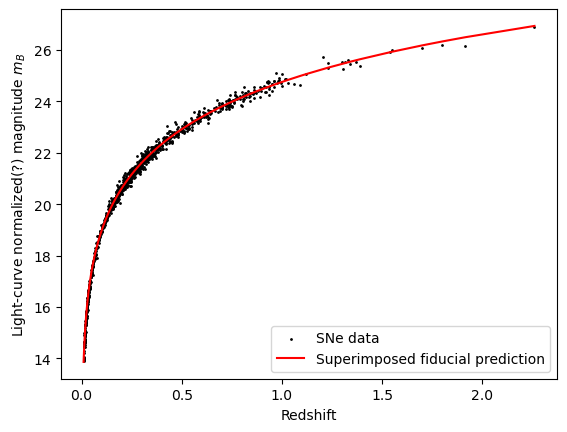

In [6]:
# Sanity check.
plt.scatter(sne_df.zcmb, sne_df.mb, color='black', label='SNe data', s=1)
plt.plot(sne_df.zcmb, MU_VEC + np.mean(sne_df.mb) - np.mean(MU_VEC), color='red', label='Superimposed fiducial prediction')
plt.xlabel('Redshift')
plt.ylabel('Light-curve normalized(?) magnitude $m_B$')
plt.legend()

# Calculate partial derivatives of $\mu$

In [7]:
# Create inputs around center vector for calculating derivatives, for Omega_M and w.
# Partial derivative of m wrt. script-M is just 1.
OMEGA_M_PERT_RANGE = 1e-4
DE_EOS_W_PERT_RANGE = 1e-4
PARAM_DELTA = 1e-6

Omega_M_x = np.arange(OMEGA_M - OMEGA_M_PERT_RANGE, OMEGA_M + OMEGA_M_PERT_RANGE, PARAM_DELTA)
de_eos_w_x = np.arange(DE_EOS_W - DE_EOS_W_PERT_RANGE, DE_EOS_W + DE_EOS_W_PERT_RANGE, PARAM_DELTA)

Omega_M_y = np.array([SNeModel(o_M, DE_EOS_W, NUISANCE).apparent_mag() for o_M in Omega_M_x])
de_eos_w_y = np.array([SNeModel(OMEGA_M, w, NUISANCE).apparent_mag() for w in de_eos_w_x])

In [8]:
Omega_M_center_ind = np.where(np.isclose(Omega_M_x, OMEGA_M, rtol=PARAM_DELTA/10))[0][0]
de_eos_w_center_ind = np.where(np.isclose(de_eos_w_x, DE_EOS_W, rtol=PARAM_DELTA/10))[0][0]
print(Omega_M_center_ind, de_eos_w_center_ind)

100 100


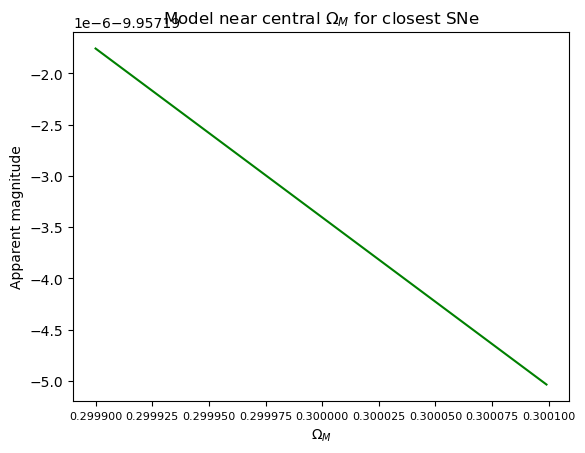

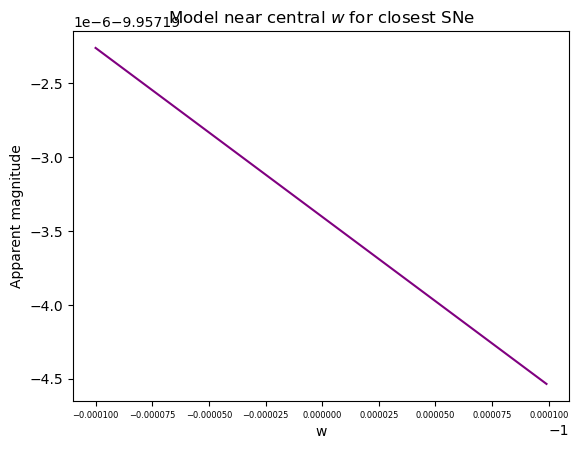

In [9]:
# Sanity check that functions are smooth near center.
plt.plot(Omega_M_x, Omega_M_y[:, 0], color='green')
plt.title(f'Model near central $\Omega_M$ for closest SNe')
plt.xlabel('$\Omega_M$')
plt.xticks(fontsize=8)
plt.ylabel('Apparent magnitude');
plt.show()
plt.plot(de_eos_w_x, de_eos_w_y[:, 0], color='purple')
plt.title(f'Model near central $w$ for closest SNe')
plt.xlabel('w')
plt.xticks(fontsize=6)
plt.ylabel('Apparent magnitude');

In [10]:
# Smooth, so OK to numerically get derivatives.
d_Omega_M_mu = np.gradient(Omega_M_y, Omega_M_x, axis=0)[Omega_M_center_ind, :]
d_w_mu = np.gradient(de_eos_w_y, de_eos_w_x, axis=0)[de_eos_w_center_ind, :]
d_nuisance_mu = np.ones_like(d_Omega_M_mu)

d_mu = (d_Omega_M_mu, d_w_mu, d_nuisance_mu)

In [11]:
# Sanity check that spacing in gradient is good.
print(d_Omega_M_mu[0], (Omega_M_y[-1, 0] - Omega_M_y[0, 0]) / (Omega_M_x[-1] - Omega_M_x[0]))
print(d_w_mu[0], (de_eos_w_y[-1, 0] - de_eos_w_y[0, 0]) / (de_eos_w_x[-1] - de_eos_w_x[0]))

-0.016479451581560434 -0.01647945179133122
-0.011419790447549035 -0.011419790907259473


# Calculate Fisher Matrix

Index order is ($\Omega_M$, $w$, $\mathcal{M}$)

Is `dmb` $\sigma$ or $\sigma^2$? Assuming latter for now.

In [19]:
fisher_mat = np.zeros((3, 3))

for i in range(len(d_mu)):
    for j in range(len(d_mu)):
        # Covariance has no dependence on model, since model is deterministic.
        fisher_mat[i, j] = np.sum(sne_df.dmb**-1 * d_mu[i] * d_mu[j])
        
print(fisher_mat)
print(f'Condition number of F is {np.linalg.cond(fisher_mat)}') # Looks OK...
fisher_inv = np.linalg.inv(fisher_mat)

[[ 2409.49074524  1023.79021602 -3420.05536171]
 [ 1023.79021602   454.95296694 -1629.41105144]
 [-3420.05536171 -1629.41105144  7688.13110096]]
Condition number of F is 1214.7988091651453


# Part a) Answer

In [20]:
for i, l in enumerate(LABELS):
    print(f'Marginalized error for {l} >= {(fisher_inv[i, i])**0.5:e}')
    print(f'Unmarginalized error for {l} >= {(fisher_mat[i, i])**-0.5:e}')
    print()

Marginalized error for $\Omega_M$ >= 1.172063e-01
Unmarginalized error for $\Omega_M$ >= 2.037217e-02

Marginalized error for $w$ >= 3.336084e-01
Unmarginalized error for $w$ >= 4.688315e-02

Marginalized error for $\mathcal{M}$ >= 2.798885e-02
Unmarginalized error for $\mathcal{M}$ >= 1.140485e-02



# Part b) Answer

In [22]:
proj_fisher_mat = np.linalg.inv(fisher_inv[:2, :2])
print(f'Condition number of marginalized F is {np.linalg.cond(proj_fisher_mat)}')
proj_fisher_inv = np.linalg.inv(proj_fisher_mat)

Condition number of marginalized F is 122.7363676424217
